In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rightway11/state-farm-distracted-driver-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/state-farm-distracted-driver-detection


In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch import nn, optim

# Paths
base_path = "/kaggle/input/state-farm-distracted-driver-detection"

train_dir = os.path.join(base_path, "imgs/train")

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 10)
model = model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_acc = 100 * correct / len(train_dataset)
    print(f"Epoch {epoch+1}: Loss={running_loss:.3f}, Train Acc={train_acc:.2f}%")

    # Validation
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
    val_acc = 100 * val_correct / len(val_dataset)
    print(f"Validation Acc: {val_acc:.2f}%")

# Save the model
torch.save(model.state_dict(), "mobilenetv2_driver_distraction.pth")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 200MB/s]


Epoch 1: Loss=130.834, Train Acc=92.55%
Validation Acc: 99.31%
Epoch 2: Loss=7.210, Train Acc=99.63%
Validation Acc: 99.46%
Epoch 3: Loss=2.921, Train Acc=99.84%
Validation Acc: 99.60%
Epoch 4: Loss=2.133, Train Acc=99.94%
Validation Acc: 99.71%


In [ ]:
# Final Test Accuracy on Validation Set
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Testing Accuracy (on validation set): {test_accuracy:.2f}%")


Final Testing Accuracy (on validation set): 99.71%


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


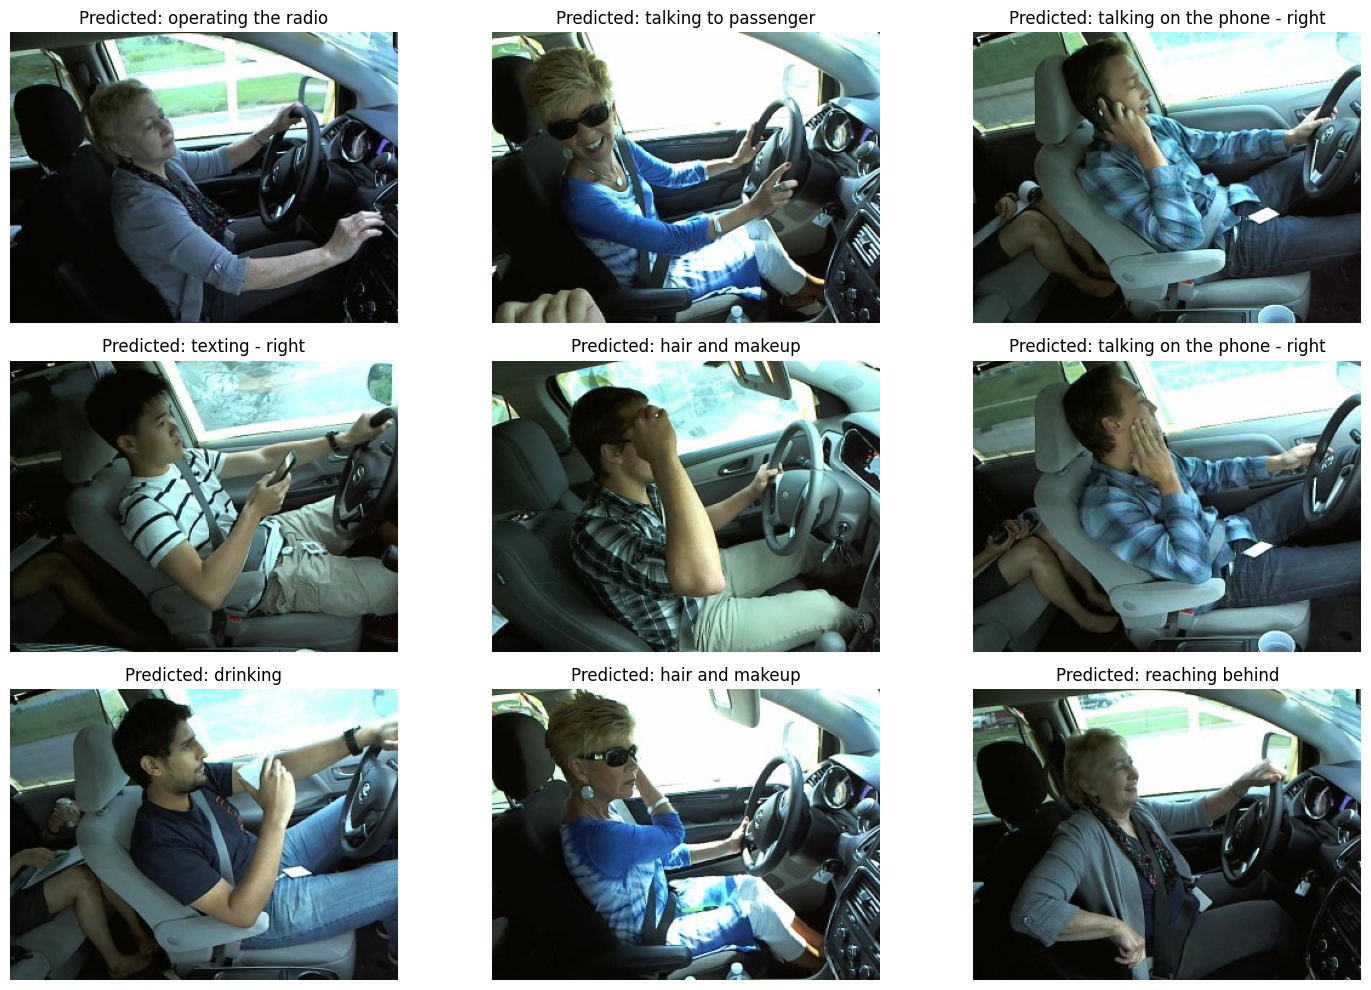

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
import numpy as np

# Test path
test_dir = os.path.join(base_path, "imgs/test")
test_images = [f for f in os.listdir(test_dir) if f.endswith(".jpg")]

# Load model
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(model.last_channel, 10)
model.load_state_dict(torch.load("mobilenetv2_driver_distraction.pth"))
model.eval().to(device)

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

class_names = [
    'safe driving', 'texting - right', 'talking on the phone - right',
    'texting - left', 'talking on the phone - left', 'operating the radio',
    'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger'
]

# Display predictions
plt.figure(figsize=(15, 10))
for i in range(9):
    img_path = os.path.join(test_dir, test_images[i])
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(f"Predicted: {class_names[predicted.item()]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


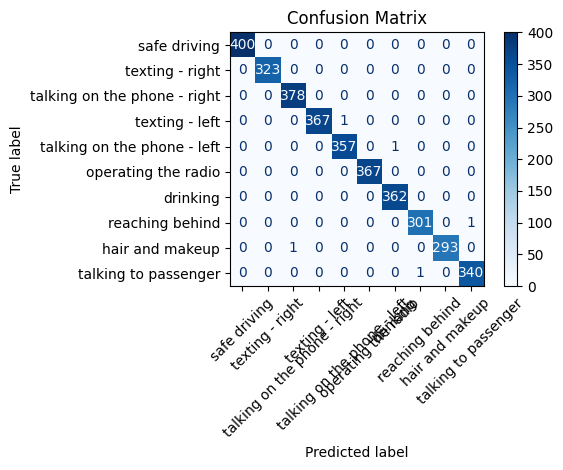

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


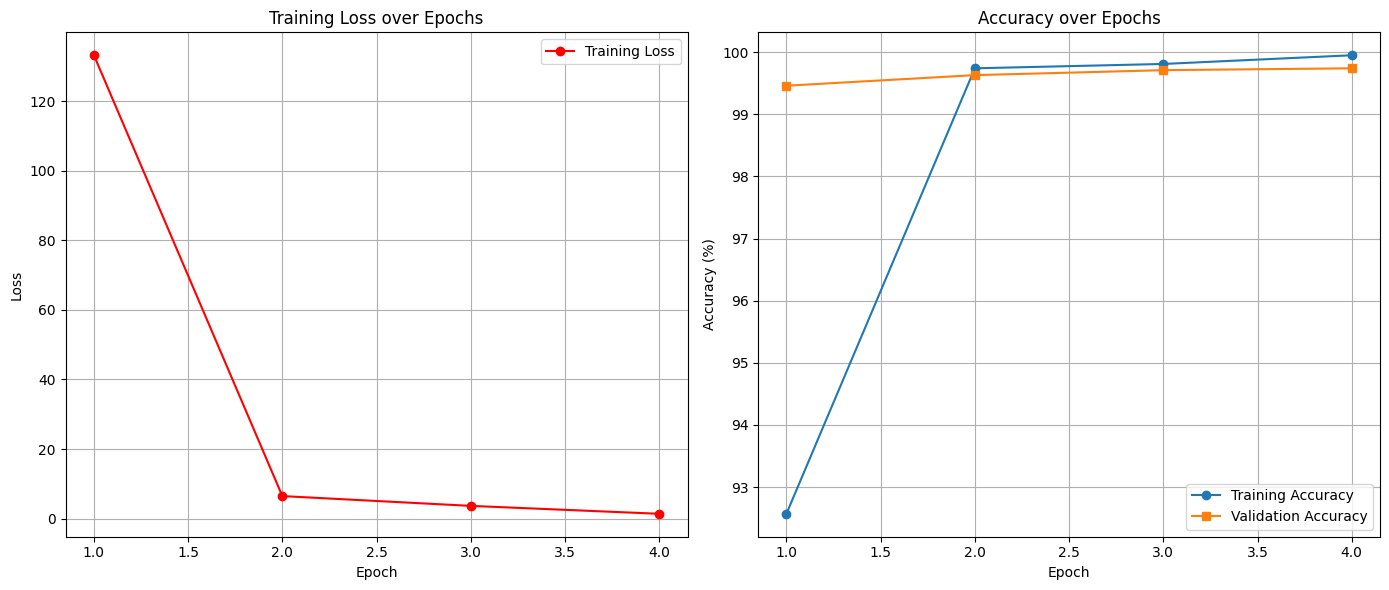

In [ ]:
import matplotlib.pyplot as plt

# Cleaned training results (last loss & last val accuracy removed)
train_losses = [133.164, 6.472, 3.658, 1.383]
train_accuracies = [92.57, 99.74, 99.81, 99.95]
val_accuracies = [99.46, 99.63, 99.71, 99.74]

epochs = range(1, len(train_losses) + 1)  # [1,2,3,4]

plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', color='red', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(epochs, val_accuracies, marker='s', label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
